# Distributions

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/ElementsOfDataScience/blob/master/08_distributions.ipynb) or
[click here to download it](https://github.com/AllenDowney/ElementsOfDataScience/raw/master/08_distributions.ipynb).

In this chapter we'll see three ways to describe a set of values:

* A probability mass function (PMF), which represents a set of values and the number of times each one appears in a dataset.

* A cumulative distribution function (CDF), which contains the same information as a PMF in a form that makes it easier to visualize, make comparisons, and perform some computations.

* A kernel density estimate (KDE), which is like a smooth, continuous version of a histogram.

For examples, we'll use data from the General Social Survey (GSS) to look at distributions of age and income, and to explore the relationship between income and education.

But we'll start with one of the most important ideas in statistics, the distribution.

## Distributions

A distribution is a set of values and their corresponding probabilities.  For example, if you roll a six-sided die, there are six possible outcomes, the numbers `1` through `6`, and they all have the same probability, `1/6`.

We can represent this distribution of outcomes with a table, like this:


| Value   |      Probability |
| -----   | -----    |
| 1       |      1/6 |
| 2       |      1/6 |
| 3       |      1/6 |
| 4       |      1/6 |
| 5       |      1/6 |
| 6       |      1/6 |

More generally, a distribution can have any number of values, the values can be any type, and the probabilities do not have to be equal.

To represent distributions in Python, we will use a library called `empiricaldist`, for "empirical distribution", where "empirical" means it is based on data rather than a mathematical formula.

The following cell checks whether `empiricaldist` is installed and installs it if necessary.

In [1]:
try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for empiricaldist: filename=empiricaldist-0.7.2-py3-none-any.whl size=12205 sha256=d45eaaaa55d0393c6dcb9a567d3b96471cf0665a9ec9283b82cf2a91bebd8f6f
  Stored in directory: /root/.cache/pip/wheels/e9/57/8a/15b864f4d5dc20cef626e3a015fec88b19df385ef30a8364cc
Successfully built empiricaldist


`empiricaldist` provides an object called `Pmf`, which stands for "probability mass function".
A `Pmf` object contains a set of possible outcomes and their probabilities.

For example, here's a `Pmf` that represents the outcome of rolling a six-sided die:

In [2]:
from empiricaldist import Pmf

outcomes = [1,2,3,4,5,6]
die = Pmf(1/6, outcomes)

The first argument is the probability of each outcome; the second argument is the list of outcomes.
We can display the result like this.

In [3]:
die

,probs
1,0.166667
2,0.166667
3,0.166667
4,0.166667
5,0.166667
6,0.166667


A `Pmf` object is a specialized version of a Pandas `Series`, so it provides all of the attributes and methods of a `Series`, plus some additional methods we'll see soon.

## The General Social Survey

Now we'll use `Pmf` objects to represent distributions of values from a new dataset, the General Social Survey (GSS).
The GSS surveys a representative sample of adult residents of the U.S. and asks questions about demographics, personal history, and beliefs about social and political issues.
It is widely used by politicians, policy makers, and researchers.

The GSS dataset contains hundreds of columns; using an online tool call [GSS Explorer](https://gssdataexplorer.norc.org/) I've selected just a few and created a subset of the data, called an **extract**.

Like the NSFG data we used in the previous chapter, the GSS data is stored in a fixed-width format, described by a Stata data dictionary.

In [4]:
dict_file = 'GSS.dct'
data_file = 'GSS.dat.gz'

The following cells download the data extract.

In [5]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

In [6]:
download('https://github.com/AllenDowney/' +
         'ElementsOfDataScience/raw/master/data/' +
         dict_file)

Downloaded GSS.dct


In [7]:
download('https://github.com/AllenDowney/' +
         'ElementsOfDataScience/raw/master/data/' +
         data_file)

Downloaded GSS.dat.gz


We will use the `statadict` library to read the data dictionary.

The following cell checks whether you have `statadict` installed and installs it if necessary.

In [8]:
try:
    from statadict import parse_stata_dict
except ImportError:
    !pip install statadict

In [9]:
from statadict import parse_stata_dict

stata_dict = parse_stata_dict(dict_file)

The data file is compressed, but we can use the `gzip` library to open it.

In [10]:
import gzip

fp = gzip.open(data_file)

The result is an object that behaves like a file, so we can pass it as an argument to `read_fwf`, which reads a fixed-width file, as we saw in the previous chapter:

In [11]:
import pandas as pd

gss = pd.read_fwf(fp,
                  names=stata_dict.names,
                  colspecs=stata_dict.colspecs)
gss.shape

(64814, 8)

The result is a `DataFrame` with one row for each respondent, and one column for each variable.
Here are the first few rows.

In [12]:
gss.head()

,YEAR,ID_,AGE,EDUC,SEX,GUNLAW,GRASS,REALINC
0,1972,1,23,16,2,1,0,18951.0
1,1972,2,70,10,1,1,0,24366.0
2,1972,3,48,12,2,1,0,24366.0
3,1972,4,27,17,2,1,0,30458.0
4,1972,5,61,12,2,1,0,50763.0


I'll explain these variables as we go along, but if you want more information, you can read the online documentation at <https://gssdataexplorer.norc.org/variables/vfilter>.

## Distribution of Education

To get started with this dataset, let's look at the distribution of `EDUC`, which records the number of years of education for each respondent.  First we'll select a column from the `DataFrame` and use `value_counts` to see what values are in it.

In [13]:
gss['EDUC'].value_counts().sort_index()

0       165
1        47
2       152
3       257
4       319
5       402
6       828
7       879
8      2724
9      2083
10     2880
11     3743
12    19663
13     5360
14     7160
15     2910
16     8355
17     1967
18     2384
19      920
20     1439
98       73
99      104
Name: EDUC, dtype: int64

The result from `value_counts` is a set of possible values and the number of times each one appears, so it is a kind of distribution.

The values `98` and `99` are special codes for "Don't know" and "No answer".
We'll use `replace` to replace these codes with `NaN`.

In [14]:
import numpy as np

educ = gss['EDUC'].replace([98, 99], np.nan)

We've already seen one way to visualize a distribution, a histogram.  Here's the histogram of education level.

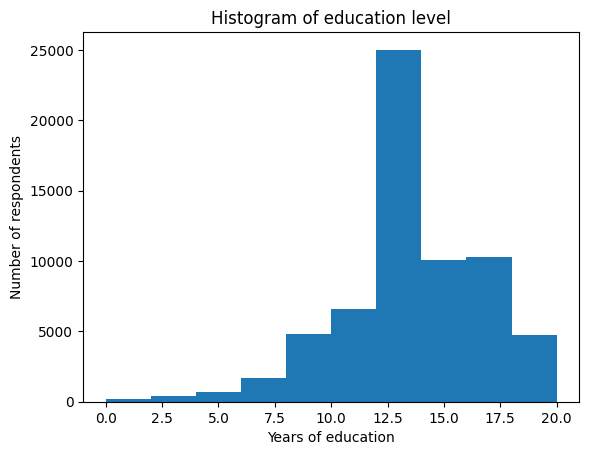

In [15]:
import matplotlib.pyplot as plt

educ.hist(grid=False)
plt.xlabel('Years of education')
plt.ylabel('Number of respondents')
plt.title('Histogram of education level');

Based on the histogram, we can see the general shape of the distribution and the central tendency -- it looks like the peak is near 12 years of education.
But a histogram is not the best way to visualize this distribution because it obscures some important details.

An alternative is to use a `Pmf`.
The function `Pmf.from_seq` takes any kind of sequence -- like a list, tuple, or Pandas `Series` -- and computes the distribution of the values in the sequence.

In [16]:
pmf_educ = Pmf.from_seq(educ, normalize=False)
type(pmf_educ)

empiricaldist.empiricaldist.Pmf

The keyword argument `normalize=False` indicates that we don't want to normalize this PMF.  I'll explain what that means soon.

Here's what the first few rows look like.

In [17]:
pmf_educ.head()

,probs
0.0,165
1.0,47
2.0,152


In this dataset, there are `165` respondents who report that they have had no formal education, and `47` who have only one year.
Here the last few rows.

In [18]:
pmf_educ.tail()

,probs
18.0,2384
19.0,920
20.0,1439


There are `1439` respondents who report that they have 20 or more years of formal education, which probably means they attended college and graduate school.

You can use the bracket operator to look up a value in a `Pmf` and get the corresponding count:

In [19]:
pmf_educ[20]

1439

Usually when we make a PMF, we want to know the *fraction* of respondents with each value, rather than the counts.  We can do that by setting `normalize=True`; then we get a **normalized** PMF, that is, a PMF where the values in the second column add up to 1.

In [20]:
pmf_educ_norm = Pmf.from_seq(educ, normalize=True)
pmf_educ_norm.head()

,probs
0.0,0.002553
1.0,0.000727
2.0,0.002352


Now if we use the bracket operator to look up a value, the result is a fraction rather than a count.
For example, the fraction of people with 12 years of education is about 30%:

In [21]:
pmf_educ_norm[12]

0.30420656899299164

`Pmf` provides a `bar` method that plots the values and their probabilities as a bar chart.

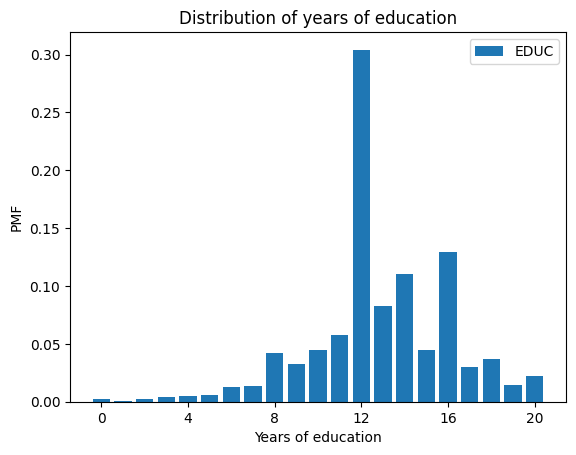

In [22]:
pmf_educ_norm.bar(label='EDUC')

plt.xlabel('Years of education')
plt.xticks(range(0, 21, 4))
plt.ylabel('PMF')
plt.title('Distribution of years of education')
plt.legend();

In this figure, we can see that the most common value is 12 years, but there are also peaks at 14 and 16, which correspond to two and four years of college.

For this data, the PMF is probably a better choice than the histogram.  The PMF shows all unique values, so we can see where the peaks are.
Because the histogram puts values into bins, it obscures these details.  With this dataset, and the default number of bins, we couldn't see the peaks at 14 and 16 years.
But PMFs have limitations, too, as we'll see.

First, here's an exercise where you can practice with PMFs.

**Exercise:** Let's look at the `YEAR` column in the `DataFrame`, which represents the year each respondent was interviewed.

Make an unnormalized `Pmf` for `YEAR` and display the result.
How many respondents were interviewed in 2018?

In [29]:
pmf_year = Pmf.from_seq(gss['YEAR'], normalize=False)
print(pmf_year)
print(f'\nIn 2018: {pmf_year[2018]}')

1972    1613
1973    1504
1974    1484
1975    1490
1976    1499
1977    1530
1978    1532
1980    1468
1982    1860
1983    1599
1984    1473
1985    1534
1986    1470
1987    1819
1988    1481
1989    1537
1990    1372
1991    1517
1993    1606
1994    2992
1996    2904
1998    2832
2000    2817
2002    2765
2004    2812
2006    4510
2008    2023
2010    2044
2012    1974
2014    2538
2016    2867
2018    2348
Name: YEAR, dtype: int64

In 2018: 2348


## Cumulative Distribution Functions

Now we'll see another way to represent a distribution, the cumulative distribution function (CDF).
`empiricaldist` provides a `Cdf` object that represents a CDF.
We can import it like this:

In [31]:
from empiricaldist import Cdf

As an example, suppose we have a sequence of five values:

In [32]:
values = 1, 2, 2, 3, 5

Here's the `Pmf` of these values.

In [33]:
Pmf.from_seq(values)

,probs
1,0.2
2,0.4
3,0.2
5,0.2


If you draw a random value from `values`, the `Pmf` tells you the chance of getting `x`, for any value of `x`.
So the probability of the value `1` is `1/5`; the probability of the value `2` is `2/5`; and the probabilities for `3` and `5` are `1/5` each.

A CDF is similar to a PMF in the sense that it contains values and their probabilities; the difference is that the probabilities in the CDF are the cumulative sum of the probabilities in the PMF.

Here's a `Cdf` object for the same five values.

In [34]:
Cdf.from_seq(values)

,probs
1,0.2
2,0.6
3,0.8
5,1.0


If you draw a random value from `values`, `Cdf` tells you the chance of getting a value *less than or equal to* `x`, for any given `x`.

So the `Cdf` of `1` is `1/5` because one of the five values in the sequence is less than or equal to 1.

The `Cdf` of 2 is `3/5` because three of the five values are less than or equal to 2.

And the `Cdf` of 5 is `5/5` because all of the values are less than or equal to 5.

## CDF of Age

Now let's look at a more substantial `Cdf`, the distribution of ages for respondents in the General Social Survey.

The variable we'll use is `'AGE'`.
According to the codebook, the range of the values is from `18` to `89`, where `89` means "89 or older".
The special codes `98` and `99` mean "Don't know" and "Didn't answer".
See <https://gssdataexplorer.norc.org/variables/53/vshow>.

We can use `replace` to replace the special codes with `NaN`.

In [35]:
age = gss['AGE'].replace([98, 99], np.nan)

We can compute the `Cdf` of these values like this:

In [36]:
cdf_age = Cdf.from_seq(age)

`Cdf` provides a method called `plot` that plots the CDF as a line.  Here's what it looks like.

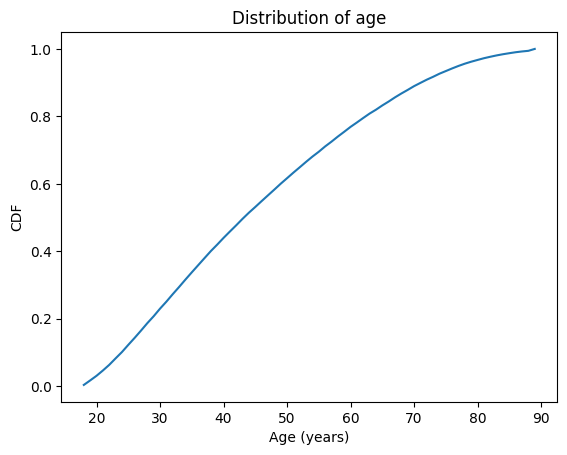

In [37]:
cdf_age.plot()

plt.xlabel('Age (years)')
plt.ylabel('CDF')
plt.title('Distribution of age');

The $x$-axis is the ages, from 18 to 89.  The $y$-axis is the cumulative probabilities, from 0 to 1.

`cdf_age` can be used as a function, so if you give it an age, it returns the corresponding probability (in a NumPy array).

In [38]:
q = 51
p = cdf_age(q)
p

array(0.63318676)

`q` stands for "quantity", which is what we are looking up.  `p` stands for probability, which is the result.
In this example, the quantity is age 51, and the corresponding probability is about `0.63`.
That means that about 63% of the respondents are 51 years old or younger.

The arrow in the following figure shows how you could read this value from the CDF, at least approximately.

In [39]:
def draw_line(p, q, x):
    xs = [q, q, x]
    ys = [0, p, p]
    plt.plot(xs, ys, ':', color='gray')

def draw_arrow_left(p, q, x):
    dx = 3
    dy = 0.025
    xs = [x+dx, x, x+dx]
    ys = [p-dy, p, p+dy]
    plt.plot(xs, ys, ':', color='gray')

def draw_arrow_down(p, q, y):
    dx = 1.25
    dy = 0.045
    xs = [q-dx, q, q+dx]
    ys = [y+dy, y, y+dy]
    plt.plot(xs, ys, ':', color='gray')

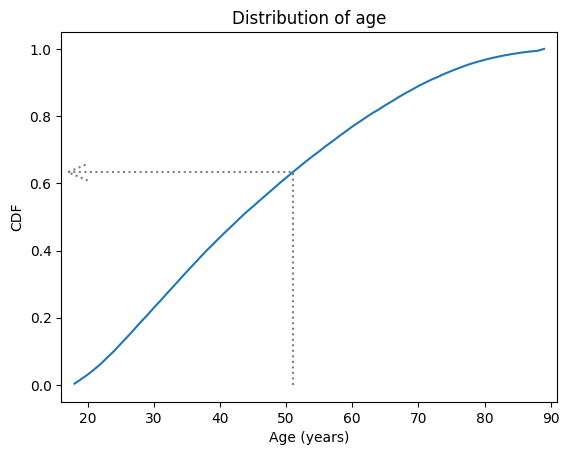

In [40]:
cdf_age.plot()

x = 17
draw_line(p, q, x)
draw_arrow_left(p, q, x)

plt.xlabel('Age (years)')
plt.xlim(x-1, 91)
plt.ylabel('CDF')
plt.title('Distribution of age');

The CDF is an invertible function, which means that if you have a probability, `p`, you can look up the corresponding quantity, `q`.
`Cdf` provides a method called `inverse` that computes the inverse of the cumulative distribution function.

In [41]:
p1 = 0.25
q1 = cdf_age.inverse(p1)
q1

array(31.)

In this example, we look up the probability `0.25` and the result is `31`.  
That means that 25% of the respondents are age 31 or less.  Another way to say the same thing is "age 31 is the 25th percentile of this distribution".

If we look up probability `0.75`, it returns `59`, so 75% of the respondents are 59 or younger.

In [42]:
p2 = 0.75
q2 = cdf_age.inverse(p2)
q2

array(59.)

In the following figure, the arrows show how you could read these values from the CDF.

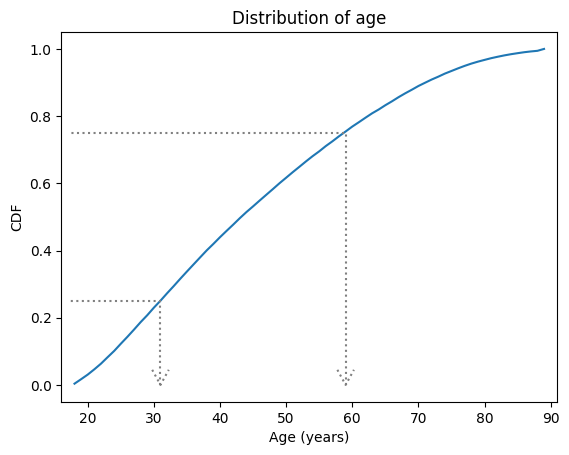

In [43]:
cdf_age.plot()

x = 17
draw_line(p1, q1, x)
draw_arrow_down(p1, q1, 0)

draw_line(p2, q2, x)
draw_arrow_down(p2, q2, 0)

plt.xlabel('Age (years)')
plt.xlim(x-1, 91)
plt.ylabel('CDF')
plt.title('Distribution of age');

The distance from the 25th to the 75th percentile is called the **interquartile range**, or IQR.  It measures the spread of the distribution, so it is similar to standard deviation or variance.

Because it is based on percentiles, it doesn't get thrown off by extreme values or outliers, the way standard deviation does.  So IQR is more **robust** than variance, which means it works well even if there are errors in the data or extreme values.

**Exercise:**  Using `cdf_age`, compute the fraction of the respondents in the GSS dataset that are *older* than 65.

In [44]:
1 - cdf_age(65)

0.16757501625739324

**Exercise:** The distribution of income in almost every country is long-tailed, which means there are a small number of people with very high incomes.
In the GSS dataset, the column `REALINC` represents total household income, converted to 1986 dollars.  We can get a sense of the shape of this distribution by plotting the CDF.

Select `REALINC` from the `gss` dataset, make a `Cdf` called `cdf_income`, and plot it.  Remember to label the axes!

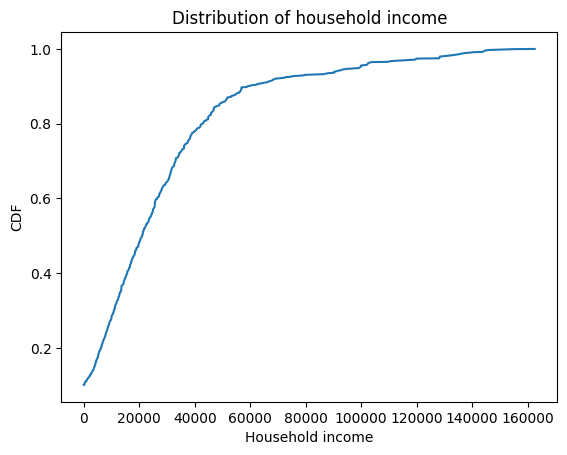

In [47]:
cdf_income = Cdf.from_seq(gss['REALINC'])
cdf_income.plot()

plt.xlabel('Household income')
plt.ylabel('CDF')
plt.title('Distribution of household income');

## Comparing Distributions

So far we've seen two ways to represent distributions, PMFs and CDFs.  Now we'll use PMFs and CDFs to compare distributions, and we'll see the pros and cons of each.

One way to compare distributions is to plot multiple PMFs on the same axes.  For example, suppose we want to compare the distribution of age for male and female respondents.

First we'll create a Boolean Series that's true for male respondents.

In [48]:
male = (gss['SEX'] == 1)

And another that's true for female respondents.

In [49]:
female = (gss['SEX'] == 2)

Now we can select ages for the male and female respondents.

In [50]:
male_age = age[male]
female_age = age[female]

And plot a PMF for each.

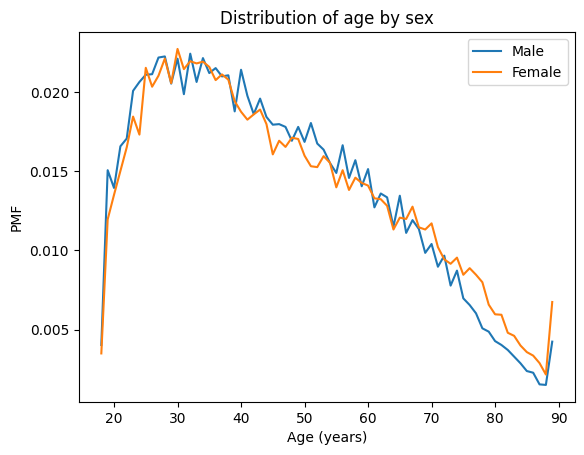

In [51]:
pmf_male_age = Pmf.from_seq(male_age)
pmf_male_age.plot(label='Male')

pmf_female_age = Pmf.from_seq(female_age)
pmf_female_age.plot(label='Female')

plt.xlabel('Age (years)')
plt.ylabel('PMF')
plt.title('Distribution of age by sex')
plt.legend();

A plot like this, which is highly variable, is often described as *noisy*.

If we ignore the noise, it looks like the PMF is higher for men between ages 40 and 50,
and higher for women between ages 70 and 80.
But both of those differences might be due to random variation.

Now let's do the same thing with CDFs; everything is the same except we replace `Pmf` with `Cdf`.

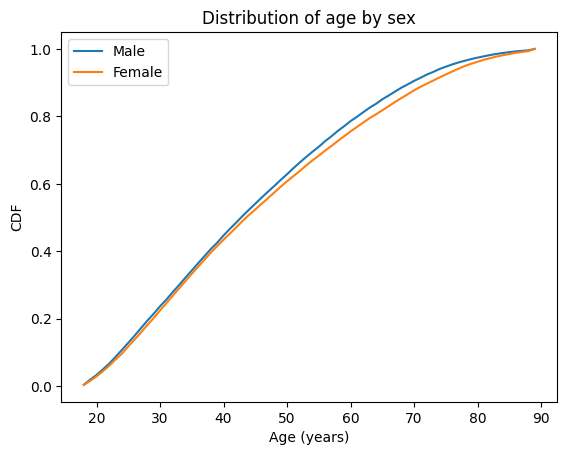

In [52]:
cdf_male_age = Cdf.from_seq(male_age)
cdf_male_age.plot(label='Male')

cdf_female_age = Cdf.from_seq(female_age)
cdf_female_age.plot(label='Female')

plt.xlabel('Age (years)')
plt.ylabel('CDF')
plt.title('Distribution of age by sex')
plt.legend();

In general, CDFs are smoother than PMFs.  Because they smooth out randomness, we can often get a better view of real differences between distributions.
In this case, the lines are close together until age 40; after that, the CDF is higher for men than women.
So what does that mean?

One way to interpret the difference is that the fraction of men below a given age is generally more than the fraction of women below the same age.
For example, about 79% of men are 60 or less, compared to 76% of women.

In [53]:
cdf_male_age(60), cdf_female_age(60)

(array(0.78599958), array(0.75529908))

Going the other way, we could also compare percentiles.
For example, the median age woman is older than the median age man, by about one year.

In [54]:
cdf_male_age.inverse(0.5), cdf_female_age.inverse(0.5)

(array(43.), array(44.))

**Exercise:** What fraction of men are over 80?  What fraction of women?

In [55]:
print(f'Men over 80: {1 - cdf_male_age(80)}')
print(f'Women over 80: {1 - cdf_female_age(80)}')

Men over 80: 0.0258566323313012
Women over 80: 0.03806458772611254


## Comparing Incomes

As another example, let's look at household income and compare the distribution before and after 1995 (I chose 1995 because it's roughly the midpoint of the survey).
The variable `REALINC` represents household income in 1986 dollars.

We'll make a Boolean `Series` to select respondents interviewed before and after 1995.

In [56]:
pre95 = (gss['YEAR'] < 1995)
post95 = (gss['YEAR'] >= 1995)

Now we can plot the PMFs.

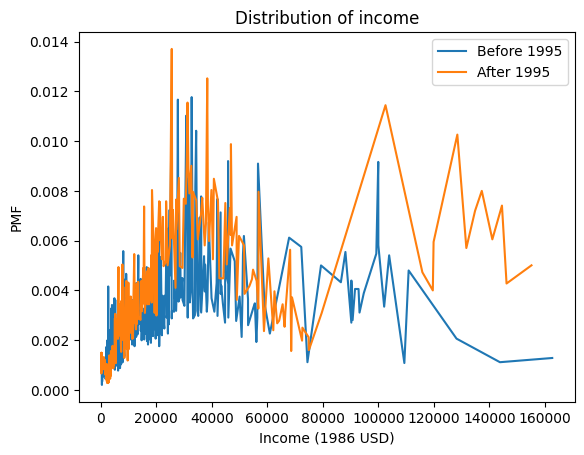

In [57]:
income = gss['REALINC'].replace(0, np.nan)

Pmf.from_seq(income[pre95]).plot(label='Before 1995')
Pmf.from_seq(income[post95]).plot(label='After 1995')

plt.xlabel('Income (1986 USD)')
plt.ylabel('PMF')
plt.title('Distribution of income')
plt.legend();

There are a lot of unique values in this distribution, and none of them appear very often.  As a result, the PMF is so noisy and we can't really see the shape of the distribution.

It's also hard to compare the distributions.
It looks like there are more people with high incomes after 1995, but it's hard to tell.  We can get a clearer picture with a CDF.

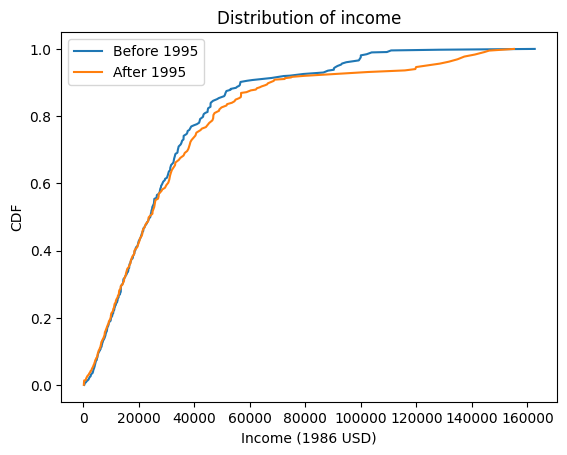

In [58]:
Cdf.from_seq(income[pre95]).plot(label='Before 1995')
Cdf.from_seq(income[post95]).plot(label='After 1995')

plt.xlabel('Income (1986 USD)')
plt.ylabel('CDF')
plt.title('Distribution of income')
plt.legend();

Below $30,000 the CDFs are almost identical; above that, we can see that the post-1995 distribution is shifted to the right.
In other words, the fraction of people with high incomes is about the same, but the income of high earners has increased.

In general, I recommend CDFs for exploratory analysis.  They give you a clear view of the distribution, without too much noise, and they are good for comparing distributions, especially if you have more than two.

**Exercise:** In the previous figure, the dollar amounts are big enough that the labels on the `x` axis are crowded.  Improve the figure by expressing income in 1000s of dollars (and update the `x` label accordingly).

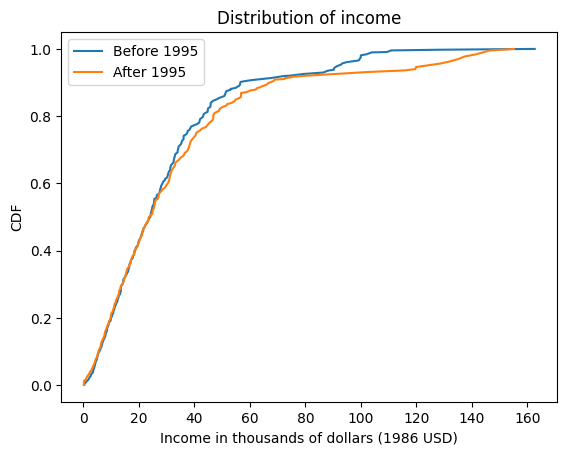

In [61]:
Cdf.from_seq(income[pre95] / 1000).plot(label='Before 1995')
Cdf.from_seq(income[post95] / 1000).plot(label='After 1995')

plt.xlabel('Income in thousands of dollars (1986 USD)')
plt.ylabel('CDF')
plt.title('Distribution of income')
plt.legend();

**Exercise:** Let's compare incomes for different levels of education in the GSS dataset

To do that we'll create Boolean `Series` to identify respondents with different levels of education.

* In the U.S, 12 years of education usually means the respondent has completed high school (secondary education).  

* A respondent with 14 years of education has probably completed an associate degree (two years of college)

* Someone with 16 years has probably completed a bachelor's degree (four years of college or university).

Define Boolean `Series` named `high`, `assc`, and `bach` that are true for respondents with

* 12 or fewer years of education,

* 13, 14, or 15 years, and

* 16 or more.

Compute and plot the distribution of income for each group.  Remember to label the CDFs, display a legend, and label the axes.
Write a few sentences that describe and interpret the results.

In [73]:
high = gss['EDUC'] < 13
assc = (gss['EDUC'] > 12) & (gss['EDUC'] < 16)
bach = gss['EDUC'] > 15

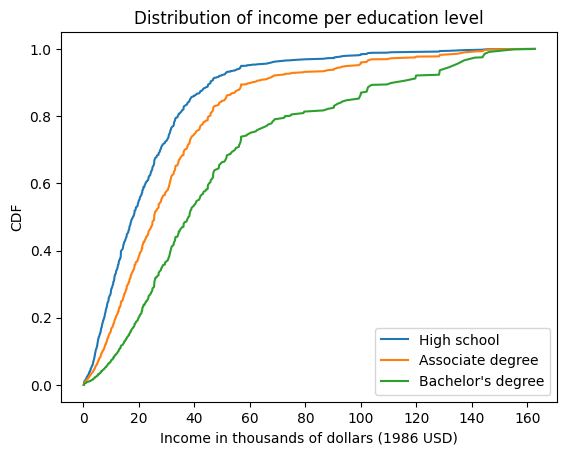

In [75]:
Cdf.from_seq(income[high] / 1000).plot(label='High school')
Cdf.from_seq(income[assc] / 1000).plot(label='Associate degree')
Cdf.from_seq(income[bach] / 1000).plot(label="Bachelor's degree")

plt.xlabel('Income in thousands of dollars (1986 USD)')
plt.ylabel('CDF')
plt.title('Distribution of income per education level')
plt.legend();

We can see the secondary education stops growing around \$60000, over 90% of people earn that or less. The associate degree is pretty close to the high school, it does not change much. There is however a slight jump around \$100000. On the other hand, income of people with bachelor's degree is very different from the previous two. The \$60000 mark represents only around 75% of people. There are noticavle jumps around \$100000 and \$130000. Generally people with bachelor's degree earn more.

## Modeling Distributions

Some distributions have names.  For example, you might be familiar with the normal distribution, also called the Gaussian distribution or the bell curve.  And you might have heard of others like the exponential distribution, binomial distribution, or maybe Poisson distribution.

These "distributions with names" are called **analytic** because they are described by analytic mathematical functions, as contrasted with empirical distributions, which are based on data.

It turns out that many things we measure in the world have distributions that are well approximated by analytic distributions, so these distributions are sometimes good models for the real world.  
In this context, what I mean by a "model" is a simplified description of the world that is accurate enough for its intended purpose.

In this section, we'll compute the CDF of a normal distribution and compare it to an empirical distribution of data.
But before we get to real data, we'll start with fake data.

The following statement uses NumPy's `random` library to generate 1000 values from a normal distribution with mean `0` and standard deviation `1`.

In [76]:
np.random.seed(17)

In [77]:
sample = np.random.normal(size=1000)

Here's what the empirical distribution of the sample looks like.

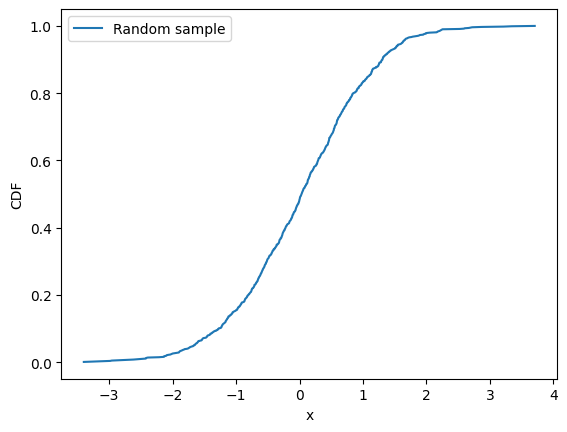

In [78]:
cdf_sample = Cdf.from_seq(sample)
cdf_sample.plot(label='Random sample')

plt.xlabel('x')
plt.ylabel('CDF')
plt.legend();

If we did not know that this sample was drawn from a normal distribution, and we wanted to check, we could compare the CDF of the data to the CDF of an ideal normal distribution, which we can use the SciPy library to compute.

In [79]:
from scipy.stats import norm

xs = np.linspace(-3, 3)
ys = norm(0, 1).cdf(xs)

First we import `norm` from `scipy.stats`, which is a collection of functions related to statistics.

Then we use `linspace()` to create an array of equally-spaced points from -3 to 3; those are the `x` values where we will evaluate the normal CDF.

Next, `norm(0, 1)` creates an object that represents a normal distribution with mean `0` and standard deviation `1`.

Finally, `cdf` computes the CDF of the normal distribution, evaluated at each of the `xs`.

I'll plot the normal CDF with a gray line and then plot the CDF of the data again.

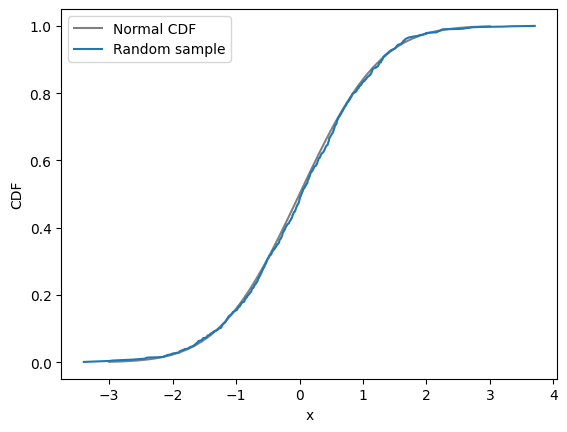

In [80]:
plt.plot(xs, ys, color='gray', label='Normal CDF')
cdf_sample.plot(label='Random sample')

plt.xlabel('x')
plt.ylabel('CDF')
plt.legend();

The CDF of the random sample agrees with the normal model.
And that's not surprising because the data were actually sampled from a normal distribution.
When we collect data in the real world, we do not expect it to fit a normal distribution as well as this.  In the next exercise, we'll try it and see.

**Exercise:** Is the normal distribution a good model for the distribution of ages in the U.S. population?

To answer this question:

* Compute the mean and standard deviation of ages in the GSS dataset.

* Use `linspace` to create an array of equally spaced values between 18 and 89.

* Use `norm` to create a normal distribution with the same mean and standard deviation as the data, then use it to compute the normal CDF for each value in the array.

* Plot the normal CDF with a gray line.

* Plot the CDF of the ages in the GSS.

How well do the plotted CDFs agree?

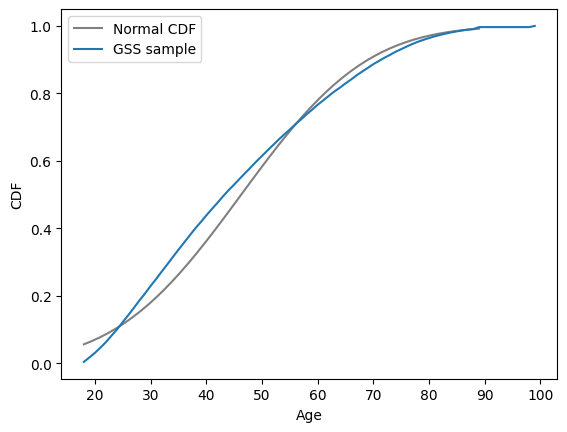

In [82]:
age_mean = gss['AGE'].mean()
age_std = gss['AGE'].std()

ages_x = np.linspace(18, 89)
ages_y = norm(age_mean, age_std).cdf(ages_x)

plt.plot(ages_x, ages_y, color='gray', label='Normal CDF')
Cdf.from_seq(gss['AGE']).plot(label='GSS sample')

plt.xlabel('Age')
plt.ylabel('CDF')
plt.legend();

**Exercise:** In many datasets, the distribution of income is approximately **lognormal**, which means that the logarithms of the incomes fit a normal distribution.  Let's see whether that's true for the GSS data.

* Extract `REALINC` from `gss` and compute its logarithm using `np.log10()`.  Hint: Replace the value `0` with `NaN` before computing logarithms.

* Compute the mean and standard deviation of the log-transformed incomes.

* Use `norm` to make a normal distribution with the same mean and standard deviation as the log-transformed incomes.

* Plot the CDF of the normal distribution.

* Compute and plot the CDF of the log-transformed incomes.

How similar are the CDFs of the log-transformed incomes and the normal distribution?

In [94]:
income = gss['REALINC'].replace(0, np.nan)
income_log = np.log10(income)
income_log_mean = income_log.mean()
income_log_std = income_log.std()

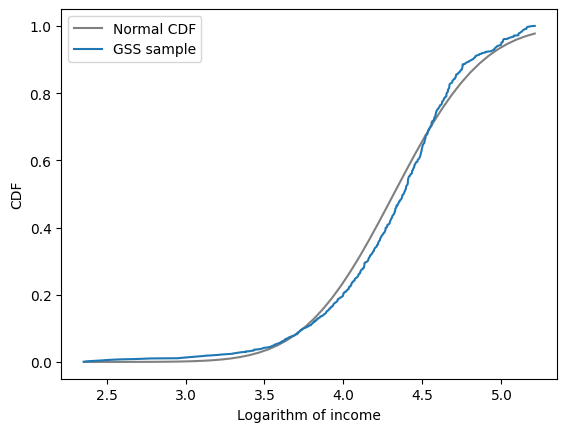

In [102]:
income_log_x = np.linspace(min(income_log), max(income_log))
income_log_y = norm(income_log_mean, income_log_std).cdf(income_log_x)
plt.plot(income_log_x, income_log_y, color='gray', label='Normal CDF')
Cdf.from_seq(income_log).plot(label='GSS sample')

plt.xlabel('Logarithm of income')
plt.ylabel('CDF')
plt.legend();

## Kernel Density Estimation

We have seen two ways to represent distributions, PMFs and CDFs.  Now we'll learn another way: a probability density function, or PDF.
The `norm` function, which we used to compute the normal CDF, can also compute the normal PDF:

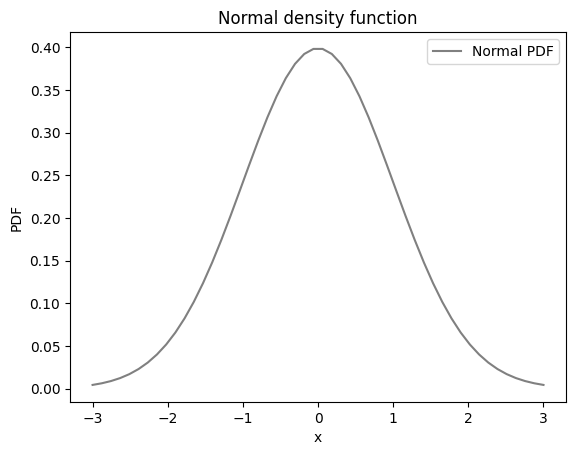

In [103]:
xs = np.linspace(-3, 3)
ys = norm(0,1).pdf(xs)
plt.plot(xs, ys, color='gray', label='Normal PDF')

plt.xlabel('x')
plt.ylabel('PDF')
plt.title('Normal density function')
plt.legend();

The normal PDF is the classic "bell curve".  

It is tempting to compare the PMF of the data to the PDF of the normal distribution, but that doesn't work.
Let's see what happens if we try:

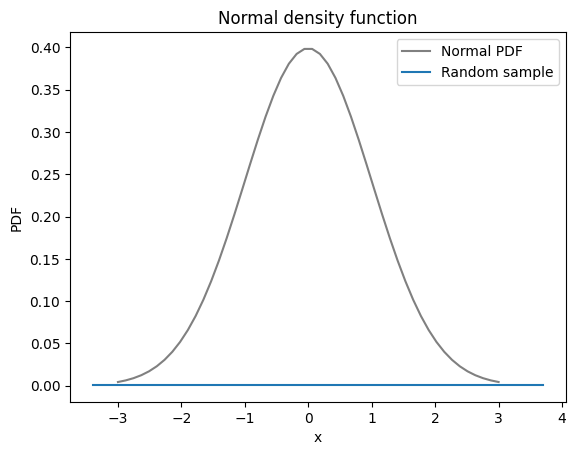

In [104]:
plt.plot(xs, ys, color='gray', label='Normal PDF')

pmf_sample = Pmf.from_seq(sample)
pmf_sample.plot(label='Random sample')

plt.xlabel('x')
plt.ylabel('PDF')
plt.title('Normal density function')
plt.legend();

The PMF of the sample is a flat line across the bottom.  In the random sample, every value is unique, so they all have the same probability, one in 1000.

However, we can use the points in the sample to estimate the PDF of the distribution they came from.
This process is called **kernel density estimation**, or KDE.  It's a way of getting from a PMF, a probability mass function, to a PDF, a probability density function.

To generate a KDE plot, we'll use the Seaborn library, imported as `sns`.
Seaborn provides `kdeplot`, which takes the sample, estimates the PDF, and plots it.

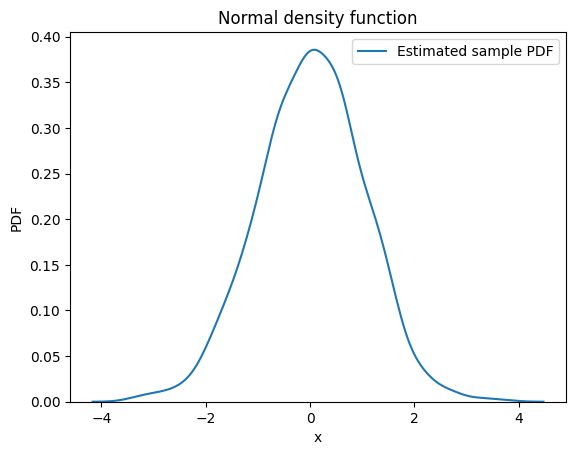

In [105]:
import seaborn as sns

sns.kdeplot(sample, label='Estimated sample PDF')

plt.xlabel('x')
plt.ylabel('PDF')
plt.title('Normal density function')
plt.legend();

Now we can compare the KDE plot and the normal PDF.

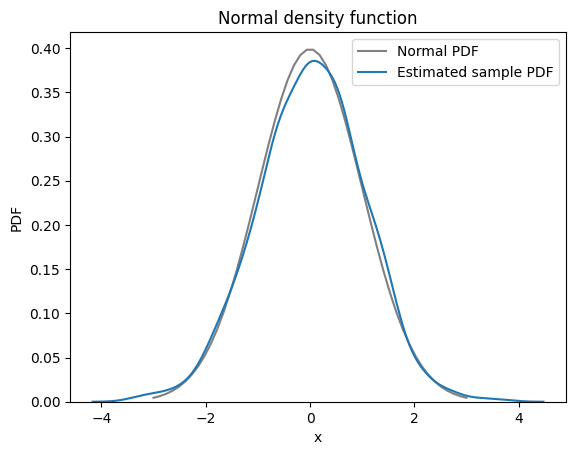

In [106]:
plt.plot(xs, ys, color='gray', label='Normal PDF')
sns.kdeplot(sample, label='Estimated sample PDF')

plt.xlabel('x')
plt.ylabel('PDF')
plt.title('Normal density function')
plt.legend();

The KDE plot matches the normal PDF pretty well, although the differences look bigger when we compare PDFs than they did with the CDFs.
That means that the PDF is a more sensitive way to look for differences, but often it is too sensitive.  
It's hard to tell whether apparent differences mean anything, or if they are just random, as in this case.

**Exercise:** In a previous exercise, we asked "Is the normal distribution a good model for the distribution of ages in the U.S. population?"  To answer this question, we plotted the CDF of the data and compared it to the CDF of a normal distribution with the same mean and standard deviation.

Now we'll compare the estimated density of the data with the normal PDF.

* Again, compute the mean and standard deviation of ages in the GSS dataset.

* Use `linspace` to create an array of values between 18 and 89.

* Use `norm` to create a normal distribution with the same mean and standard deviation as the data, then use it to compute the normal PDF for each value in the array.

* Plot the normal PDF with a gray line.

* Use `sns.kdeplot` to estimate and plot the density of the ages in the GSS.  

Note: Seaborn can't handle NaNs, but you can use `dropna` to drop them before calling `kdeplot`.

How well do the PDF and KDE plots agree?

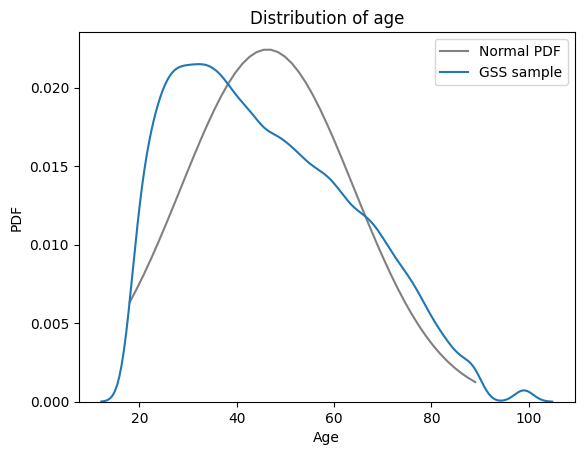

In [110]:
ages_mean = gss['AGE'].mean()
ages_std = gss['AGE'].std()

ages_x = np.linspace(18, 89)
ages_y = norm(ages_mean, ages_std).pdf(ages_x)

plt.plot(ages_x, ages_y, color='gray', label='Normal PDF')
sns.kdeplot(gss['AGE'], label='GSS sample')

plt.xlabel('Age')
plt.ylabel('PDF')
plt.title('Distribution of age')
plt.legend();

**Exercise:** In a previous exercise, we used CDFs to see if the distribution of income fits a lognormal distribution.  We can make the same comparison using a PDF and KDE.

* Again, extract `REALINC` from `gss` and compute its logarithm using `np.log10()`.

* Compute the mean and standard deviation of the log-transformed incomes.

* Use `norm` to make a normal distribution with the same mean and standard deviation as the log-transformed incomes.

* Plot the PDF of the normal distribution.

* Use `sns.kdeplot()` to estimate and plot the density of the log-transformed incomes.

In [112]:
income = gss['REALINC'].replace(0, np.nan)
income_log = np.log10(income)
income_log_mean = income_log.mean()
income_log_std = income_log.std()

income_log_x = np.linspace(min(income_log), max(income_log))
income_log_y = norm(income_log_mean, income_log_std).pdf(income_log_x)

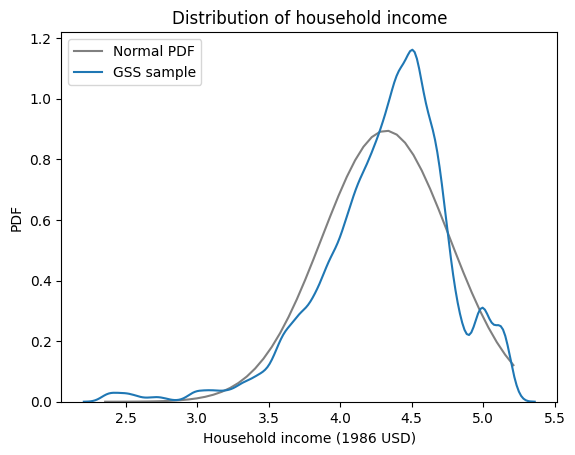

In [117]:
plt.plot(income_log_x, income_log_y, color='gray', label='Normal PDF')
sns.kdeplot(income_log, label='GSS sample')

plt.xlabel('Household income (1986 USD)')
plt.ylabel('PDF')
plt.title('Distribution of household income')
plt.legend();

## Summary

In this chapter, we've seen four ways to visualize distributions, PMFs, CDFs, and KDE plots.

In general, I use CDFs when I am exploring data.
That way, I get the best view of what's going on without getting distracted by noise.

Then, if I am presenting results to an audience unfamiliar with CDFs, I might use a PMF if the dataset contains a small number of unique values, or KDE if there are many unique values.

*Elements of Data Science*

Copyright 2021 [Allen B. Downey](https://allendowney.com)

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)